In [ ]:
!nvidia-smi

Mon Jul 31 14:29:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Download video

In [ ]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_pvs9MoyW-eEYf4XMeV4U-eiAcRtyIX3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1_pvs9MoyW-eEYf4XMeV4U-eiAcRtyIX3" -O demovideo.mp4 && rm -rf /tmp/cookies.txt

/content
--2023-07-31 14:29:44--  https://docs.google.com/uc?export=download&confirm=&id=1_pvs9MoyW-eEYf4XMeV4U-eiAcRtyIX3
Resolving docs.google.com (docs.google.com)... 108.177.127.139, 108.177.127.101, 108.177.127.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.127.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ruii08mgui89cb5i8ro6ob8fn5uq744g/1690813725000/11292777736670267891/*/1_pvs9MoyW-eEYf4XMeV4U-eiAcRtyIX3?e=download&uuid=9f52ffc9-d8db-4967-93de-9eae41e3fdd0 [following]
--2023-07-31 14:29:46--  https://doc-0k-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ruii08mgui89cb5i8ro6ob8fn5uq744g/1690813725000/11292777736670267891/*/1_pvs9MoyW-eEYf4XMeV4U-eiAcRtyIX3?e=download&uuid=9f52ffc9-d8db-4967-93de-9eae41e3fdd0
Resolving doc-0k-40-docs.googleusercontent.com (doc-0k-40-docs.googleusercontent.com)... 172.

In [ ]:
import numpy as np

import cv2

VIDEO = "/content/demovideo.mp4"

In [ ]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.145 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 25.5 GB RAM, 24.6/166.8 GB disk)


In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [ ]:
# settings
MODEL = "/content/drive/MyDrive/best (2).pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11127519 parameters, 0 gradients, 28.4 GFLOPs


## Predict and annotate single frame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7, 9]


0: 640x384 1 pepsi, 64.0ms
Speed: 4.3ms preprocess, 64.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


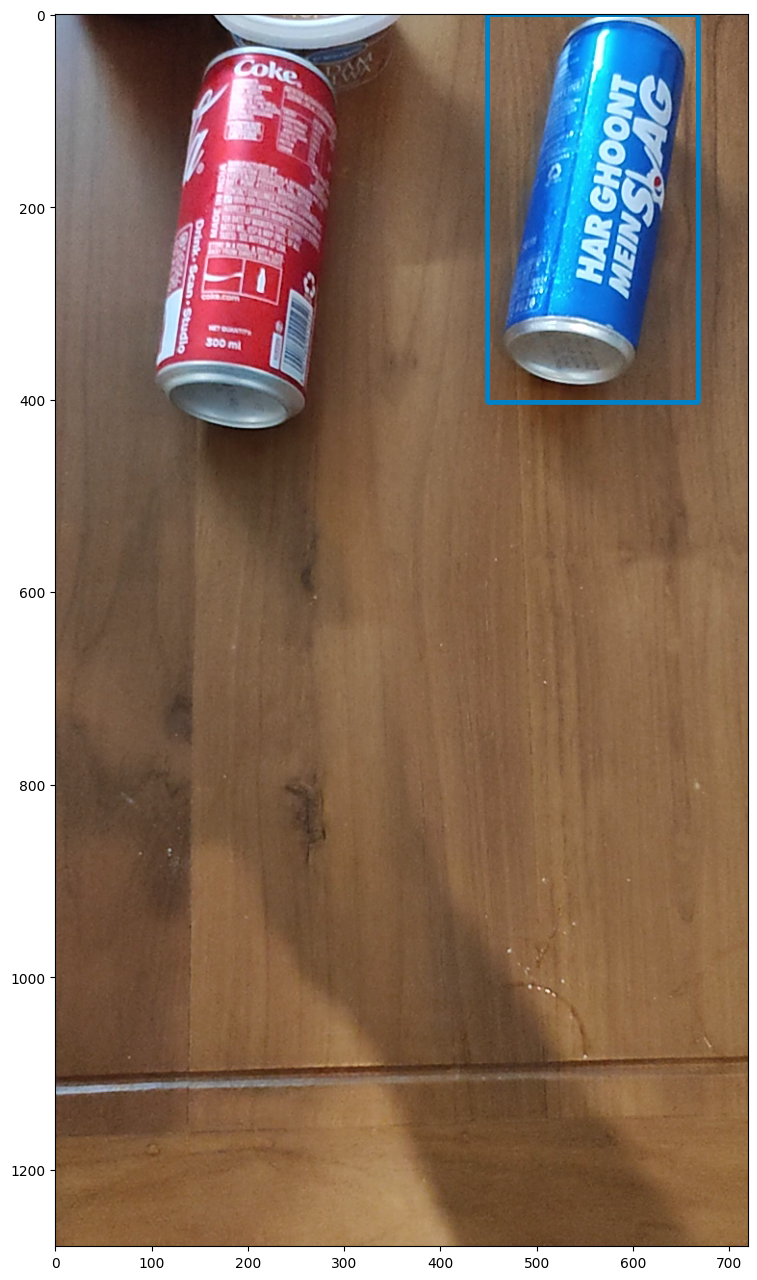

In [ ]:
# create frame generator
generator = get_video_frames_generator(VIDEO)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

## Predict and annotate whole video

In [ ]:
# settings
LINE_START = Point(0, 648)
LINE_END = Point(720, 648)

TARGET_VIDEO_PATH = f"{HOME}/result5.mp4"

In [ ]:
VideoInfo.from_video_path(VIDEO)

VideoInfo(width=720, height=1280, fps=30, total_frames=1546)

In [ ]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(VIDEO)
# create frame generator
generator = get_video_frames_generator(VIDEO)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"{confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/1546 [00:00<?, ?it/s]


0: 640x384 1 pepsi, 10.9ms
Speed: 3.4ms preprocess, 10.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 cokes, 1 pepsi, 11.4ms
Speed: 2.6ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 coke, 1 pepsi, 11.3ms
Speed: 2.9ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 cokes, 1 pepsi, 11.7ms
Speed: 2.1ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 cokes, 1 pepsi, 10.9ms
Speed: 2.3ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 cokes, 1 pepsi, 10.8ms
Speed: 2.1ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 coke, 1 pepsi, 11.1ms
Speed: 2.5ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 coke, 1 pepsi, 10.9ms
Speed: 2.2ms preprocess, 10.9ms infer